In [28]:
import json
import pytesseract
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Specify the path to the tesseract executable (adjust to your system's path)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example

# Load dataset
def load_data(path):
    df = pd.read_json(path, lines=True)
    
    df["label"] = df.annotation.apply(lambda x: x.get('label'))
    df["label"] = df.label.apply(lambda x: x[0])
    
    X = df.content.values
    y = df.label.values
    
    return X, y

# Tokenization function
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


In [29]:
# Load and Split Data
url = 'Dataset.json'
X, y = load_data(url)

# Splitting into 70-30 and 80-20 training-testing sets
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization
vect = CountVectorizer(tokenizer=tokenize, token_pattern=None)  # Set token_pattern=None to avoid the warning
tfidf = TfidfTransformer()
clf = RandomForestClassifier()  # RandomForestClassifier initialized without output

# Train classifier for 70% training data
X_train_counts = vect.fit_transform(X_train_70)
X_train_tfidf = tfidf.fit_transform(X_train_counts)
clf.fit(X_train_tfidf, y_train_70)


RandomForestClassifier()


--- Confusion Matrix (20% Testing Data) ---
Labels: ['0' '1']
Confusion Matrix:
 [[2314  110]
 [ 145 1432]]
Accuracy: 0.9362659335166208


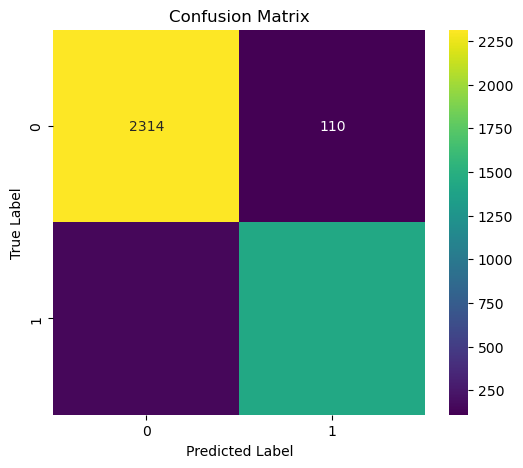


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      2424
           1       0.93      0.91      0.92      1577

    accuracy                           0.94      4001
   macro avg       0.93      0.93      0.93      4001
weighted avg       0.94      0.94      0.94      4001


--- Confusion Matrix (30% Testing Data) ---
Labels: ['0' '1']
Confusion Matrix:
 [[3506  160]
 [ 214 2121]]
Accuracy: 0.9376770538243626


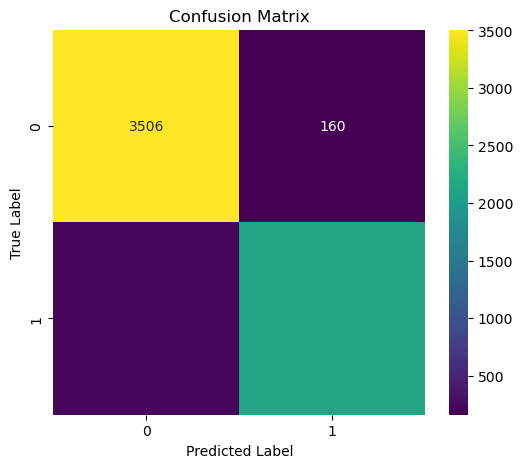


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      3666
           1       0.93      0.91      0.92      2335

    accuracy                           0.94      6001
   macro avg       0.94      0.93      0.93      6001
weighted avg       0.94      0.94      0.94      6001



In [30]:
# Predictions for 20% testing set
X_test_counts_20 = vect.transform(X_test_20)
X_test_tfidf_20 = tfidf.transform(X_test_counts_20)
y_pred_20 = clf.predict(X_test_tfidf_20)

# Predictions for 30% testing set
X_test_counts_30 = vect.transform(X_test_30)
X_test_tfidf_30 = tfidf.transform(X_test_counts_30)
y_pred_30 = clf.predict(X_test_tfidf_30)

def display_results(y_test, y_pred):
    labels = np.unique(np.concatenate((y_test, y_pred)))  # Ensure all labels are considered
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

    # Plot Confusion Matrix with proper labels
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="viridis", cbar=True, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display results for 20% testing data
print("\n--- Confusion Matrix (20% Testing Data) ---")
display_results(y_test_20, y_pred_20)

# Display results for 30% testing data
print("\n--- Confusion Matrix (30% Testing Data) ---")
display_results(y_test_30, y_pred_30)


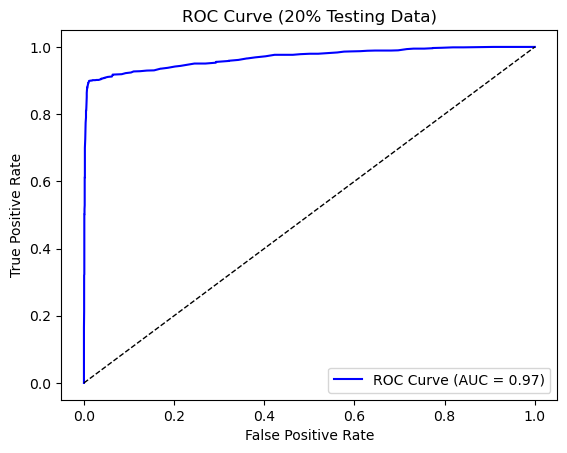

In [31]:
 # ROC Curve for 20% Testing Data
y_prob_20 = clf.predict_proba(X_test_tfidf_20)[:, 1]
fpr, tpr, _ = roc_curve(y_test_20, y_prob_20, pos_label=clf.classes_[1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (20% Testing Data)')
plt.legend()
plt.show()

In [51]:
# Prediction Example
X_test_counts_sample = vect.transform(["the hormones are worse for guys.  I cant tell you how much I truly hate the thoughts that go through my head"])  # Replace with a different example if needed
X_test_tfidf_sample = tfidf.transform(X_test_counts_sample)
print("\nSample Prediction: {}\n".format(clf.predict(X_test_tfidf_sample)))


Sample Prediction: ['1']



In [15]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from collections import Counter

# Hyperparameters
max_words = 5000
max_len = 100

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train_70)

# Convert texts to sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_70), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_20), maxlen=max_len)

# Convert labels to numerical format
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_train_encoded = np.array([label_map[label] for label in y_train_70])
y_test_encoded = np.array([label_map[label] for label in y_test_20])

# Print class distribution
print(f"Class distribution: {Counter(y_train_encoded)}")

# Adjusted class weights
class_weights = {0: 3.0, 1: 5.0}  # Increase class 0 weight

# Build LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)  # Reduce learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_seq, y_train_encoded, epochs=20, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate on test set
y_pred = model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)

# Display classification metrics
print(classification_report(y_test_encoded, y_pred_labels, target_names=label_map.keys()))


# Function to extract text from an image (example)
def extract_text_from_image(image_path):
    img = Image.open(image_path)
    return pytesseract.image_to_string(img).strip()

# Function to predict from the extracted image text
def predict_from_image(image_path):
    text = extract_text_from_image(image_path)
    print(f"Extracted Text: {text}")  # Debug: Print extracted text
    
    # Random Forest Prediction (assuming clf, vect, tfidf are defined earlier)
    X_test_counts_sample = vect.transform([text])
    X_test_tfidf_sample = tfidf.transform(X_test_counts_sample)
    rf_prediction = clf.predict(X_test_tfidf_sample)
    
    # LSTM Prediction
    X_test_seq_sample = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)
    lstm_prediction_probs = model.predict(X_test_seq_sample)  # Get prediction probabilities
    lstm_prediction = np.argmax(lstm_prediction_probs, axis=1)
    lstm_label = [key for key, val in label_map.items() if val == lstm_prediction[0]][0]
    
    # Debug: Print LSTM prediction probabilities
    print(f"LSTM Prediction Probabilities: {lstm_prediction_probs}")
    
    return rf_prediction[0], lstm_label

# Example usage of image prediction
image_path = 'Image.jpg'
rf_pred, lstm_pred = predict_from_image(image_path)
print(f"LSTM Prediction: {lstm_pred}")


Class distribution: Counter({0: 8513, 1: 5487})
Epoch 1/20


C:\Users\Kaushik\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


394/394 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5878 - loss: 2.4955 - val_accuracy: 0.7493 - val_loss: 0.5115
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.7916 - loss: 1.6699 - val_accuracy: 0.7879 - val_loss: 0.4629
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8577 - loss: 1.2586 - val_accuracy: 0.8071 - val_loss: 0.4475
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9010 - loss: 0.9695 - val_accuracy: 0.8257 - val_loss: 0.4597
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9288 - loss: 0.7658 - val_accuracy: 0.8293 - val_loss: 0.4670
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9415 - loss: 0.6122 - val_accuracy: 0.8457 - val_loss: 0.4958
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9515 - loss: 0.4766 - val_accuracy: 0.8443 - val_loss: 0.6200
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9612 - loss: 0.4344 - val_accurac

In [47]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from collections import Counter

# Hyperparameters
max_words = 5000
max_len = 100

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train_70)

# Convert texts to sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_70), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_20), maxlen=max_len)

# Convert labels to numerical format
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_train_encoded = np.array([label_map[label] for label in y_train_70])
y_test_encoded = np.array([label_map[label] for label in y_test_20])

# Print class distribution
print(f"Class distribution: {Counter(y_train_encoded)}")

# Adjusted class weights
class_weights = {0: 3.0, 1: 5.0}  # Increase class 0 weight

# Build LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)  # Reduce learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_seq, y_train_encoded, epochs=5, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate on test set
y_pred = model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)

# Display classification metrics
print(classification_report(y_test_encoded, y_pred_labels, target_names=label_map.keys()))

# Function to predict from text input
def predict_from_text(text):
    # Convert text to sequence
    X_test_seq_sample = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)

    # Debugging: Print tokenized sequence
    print(f"Tokenized Input Sequence: {X_test_seq_sample}")

    # Get LSTM model predictions
    lstm_prediction_probs = model.predict(X_test_seq_sample)
    
    # Debugging: Print probability scores
    print(f"LSTM Prediction Probabilities: {lstm_prediction_probs}")

    # Apply thresholding: Predict 0 if probability > 0.5
    predicted_class = np.argmax(lstm_prediction_probs, axis=1)[0]
    predicted_prob = lstm_prediction_probs[0][predicted_class]

    if predicted_class == 1 and lstm_prediction_probs[0][0] > 0.5:
        predicted_class = 0  # Override if class 0 probability is high

    lstm_label = [key for key, val in label_map.items() if val == predicted_class][0]

    return lstm_label

# Example test case
text = "I cant tell you how much I truly love the thoughts that go through my head."
lstm_pred = predict_from_text(text)
print(f"LSTM Prediction: {lstm_pred}")


Class distribution: Counter({0: 8513, 1: 5487})
Epoch 1/5


C:\Users\Kaushik\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5702 - loss: 2.5106 - val_accuracy: 0.7164 - val_loss: 0.5411
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7865 - loss: 1.6779 - val_accuracy: 0.7757 - val_loss: 0.4612
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8480 - loss: 1.3342 - val_accuracy: 0.8021 - val_loss: 0.4590
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8990 - loss: 0.9724 - val_accuracy: 0.8179 - val_loss: 0.4550
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9243 - loss: 0.7657 - val_accuracy: 0.8343 - val_loss: 0.4890
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      2424
           1       0.72      0.86      0.79      1577

    accuracy                           0.82      4001
   macro avg       0.81      0.82      0.81      4001
weighted avg       0.83      0.82      0.82      40